In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import time

# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

c:\Users\jonas\miniconda3\envs\ModelML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Data/data_pre.csv", index_col=0)

In [3]:
df["FL_DATE"]=pd.to_datetime(df["FL_DATE"]).dt.dayofyear

In [4]:
df["DEP_TIME"] = pd.to_datetime(df["DEP_TIME"]).dt.hour

In [5]:
df.head()

,FL_DATE,DEP_TIME,TAXI_OUT,DEP_DELAY,TEMP,WIND,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_US,OP_CARRIER_United Airlines
0,1,22,18.0,121.0,34.7,12.4,0,0,0,1,0,0,0,0,0,0
1,1,16,21.0,7.0,38.1,12.9,0,0,0,1,0,0,0,0,0,0
2,1,22,23.0,3.0,34.7,12.4,0,0,0,1,0,0,0,0,0,0
3,1,10,23.0,-1.0,35.4,13.0,0,0,0,1,0,0,0,0,0,0
4,1,18,31.0,-3.0,36.5,12.8,0,0,0,1,0,0,0,0,0,0


In [6]:
y = df.groupby('FL_DATE', as_index=False)['DEP_DELAY'].mean()


In [7]:
y = y[["DEP_DELAY"]]

In [8]:
y = y.values.ravel()

In [9]:
len(y)

181

In [10]:
ix_train = range(0, 120)
ix_test = range(120, 181)
N_train = len(ix_train)
N_test = len(ix_test)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y[ix_train]
y_test = y[ix_test]


# standardize 
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std

# standardize 
y_test_mean = y_test.mean()
y_test_std = y_test.std()
y_test = (y_test - y_test_mean) / y_test_std

N_train: 120
N_test: 61


In [11]:
y_train

array([ 0.33832633,  1.86805681,  2.88339205,  0.55177746, -0.15124448,
       -0.40512121, -0.30849509, -0.02685777, -0.33604851, -0.03286203,
       -0.24901539, -0.46066304, -0.65077146, -0.54591966, -0.38474141,
        0.47333951, -0.17793402,  0.13612391, -0.60467145, -0.65406685,
       -0.63067547, -0.56441606, -0.71127815,  0.63975019,  2.22843131,
       -0.6920882 , -0.89241124, -0.34781763, -0.56096817, -0.55020409,
       -0.46839653, -0.61371506, -0.71273126, -0.60387371, -0.65161374,
       -0.09451991, -0.33034196, -0.51071335, -0.51078612, -0.30912326,
        0.34793637,  1.01090352,  0.34751608, -0.11013457, -0.3292417 ,
       -0.08722004,  3.0861368 ,  0.18048911, -0.29930674, -0.25739029,
       -0.56861386, -0.53322882, -0.49670613,  0.67349694,  0.31718935,
        0.83327223,  5.93840868,  0.14587365, -0.48091511, -0.16286072,
       -0.20139866, -0.03271169, -0.24642481, -0.15748208, -0.20108366,
        0.0566765 , -0.51131962, -0.46362806, -0.56292735,  0.03

In [12]:
def f(carry, noise_t):
  beta1, beta2, z_prev1, z_prev2, tau = carry
  z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
  z_prev1 = z_prev2
  z_prev2 = z_t
  return (beta1, beta2, z_prev1, z_prev2, tau), z_t

In [13]:

def model(T, T_forecast, obs=None):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
    # Your code here
    """
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=5.))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=5.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0., scale=3.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0., scale=3.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    # Your code here
    """
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred) - note that you don't need a pyro.plate!
    # Your code here
    """
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs[:T])
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

In [14]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs=y_train[:])

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 4000/4000 [00:39<00:00, 101.26it/s, 255 steps of size 5.00e-03. acc. prob=1.00]


Total time: 0.887m


In [15]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta_1     -0.34      0.20     -0.34     -0.67     -0.04     68.45      1.02
     beta_2      0.82      0.23      0.83      0.46      1.23     46.71      1.06
  noises[0]      0.47      1.03      0.43     -1.20      2.20    137.30      1.03
  noises[1]     -0.17      0.85     -0.16     -1.59      1.20    302.94      1.01
  noises[2]     -0.06      0.91     -0.07     -1.55      1.51    295.93      1.00
  noises[3]     -0.07      0.81     -0.09     -1.44      1.21    390.55      1.00
  noises[4]      0.07      0.81      0.05     -1.20      1.48    334.24      1.02
  noises[5]     -0.06      0.83     -0.07     -1.47      1.29    413.94      1.00
  noises[6]     -0.13      0.86     -0.14     -1.48      1.40    337.88      1.00
  noises[7]     -0.15      0.83     -0.14     -1.45      1.24    308.24      1.00
  noises[8]     -0.22      0.83     -0.21     -1.59      1.19    265.21      1.00
  noises[9]    

In [16]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

c:\Users\jonas\miniconda3\envs\ModelML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


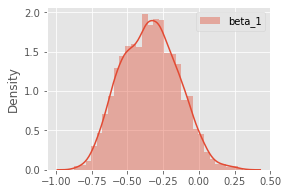

c:\Users\jonas\miniconda3\envs\ModelML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


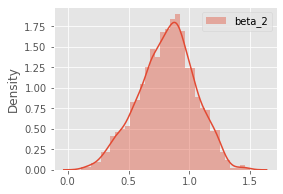

c:\Users\jonas\miniconda3\envs\ModelML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


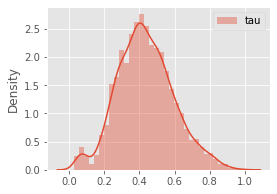

c:\Users\jonas\miniconda3\envs\ModelML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


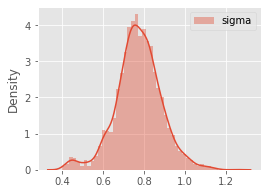

In [17]:
nodes = ["beta_1", "beta_2", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.distplot(hmc_samples[node], label=node)
  plt.legend()
  plt.show()

In [18]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

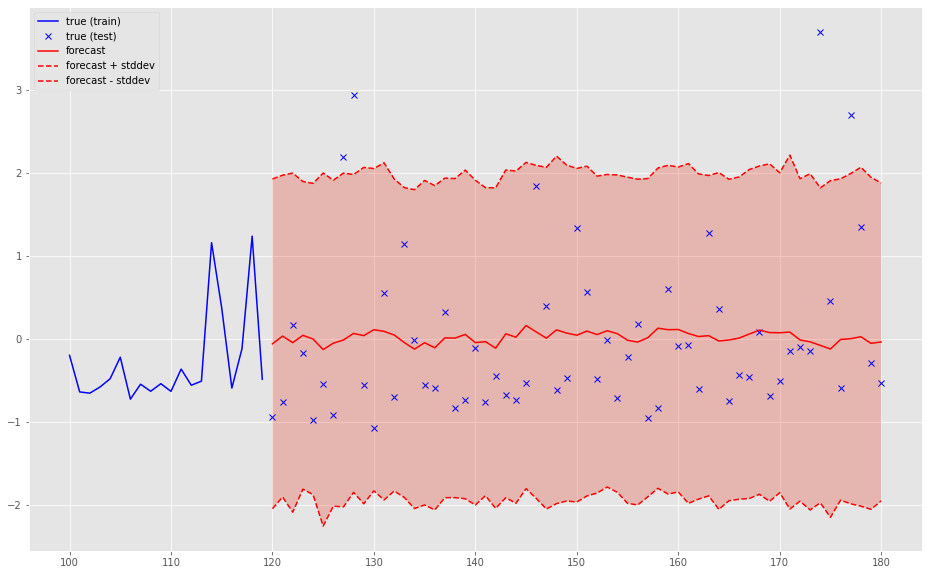

In [19]:
plt.plot(ix_train[-20:], y_train[-20:], "b-")
plt.plot(ix_test, y_test[:], "bx")
plt.plot(ix_test, y_pred_mean, "r-")
plt.plot(ix_test, y_pred_025, "r--")
plt.plot(ix_test, y_pred_975, "r--")
plt.fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

In [26]:
# get mean and standard devitions for predictions
y_hat = hmc_samples["y_pred"].mean(axis=0)


In [27]:
# convert back to the original scale
preds = y_hat * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean

In [28]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [29]:
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: -0.050
MAE: 8.47552
RMSE: 11.53639
R2: 0.000
